# Modelling (in work)

#### Research Questions:
- What factors have the most significant impact on movie revenue?
- Can we predict movie revenue accurately using pre-release features (budget, cast, director)?
- How do audience and critic reviews influence box office success?


## 0.setup

In [27]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression


notebook_dir = Path().resolve()
project_root  = notebook_dir.parent
data_path     = project_root / "data_collection" / "omdb_cleaned.csv"

df = pd.read_csv(data_path)

## 1. What factors have the most significant impact on movie revenue?


l

In [ ]:
#removing tv-series from the dataset
#because they have interval years like 2010-2015
mask_bad_year = ~df['Year'].astype(str).str.match(r'^\d{4}$', na=False)
df = df.loc[~mask_bad_year].copy()
df['Year'] = df['Year'].astype(int)

df['Runtime'] = pd.to_numeric(
    df['Runtime'].astype(str).str.extract(r'(\d+)', expand=False),
    errors='coerce'
)

numeric_feats = ['Year', 'Runtime', 'imdbRating', 'imdbVotes']
target = 'BoxOffice'
model_df = df[numeric_feats + [target]].dropna()

corrs = model_df.corr()[target].drop(target).sort_values(ascending=False)
print(corrs)

imdbVotes     0.714709
Runtime       0.284367
imdbRating    0.248918
Year          0.133745
Name: BoxOffice, dtype: float64


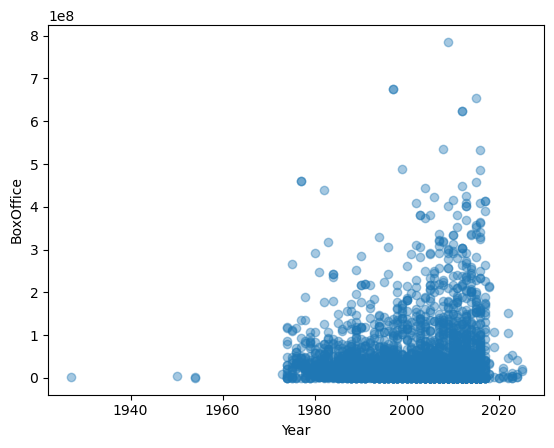

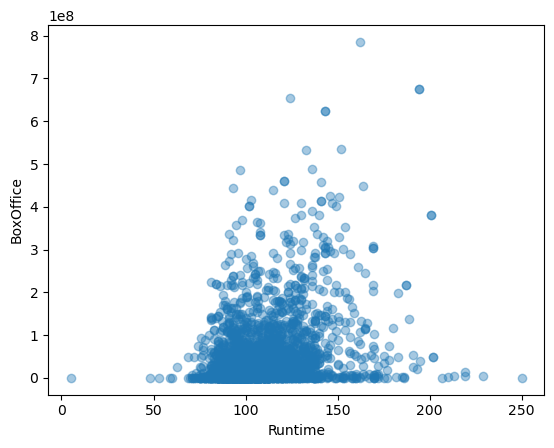

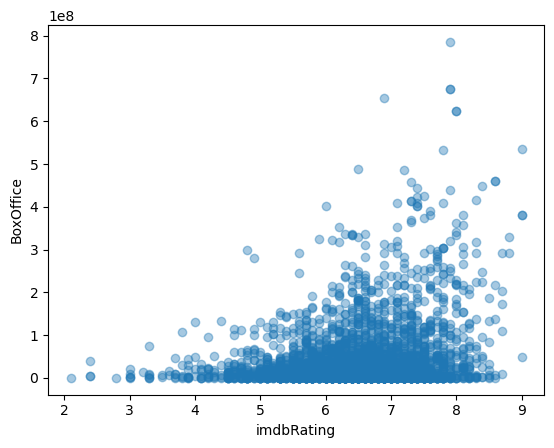

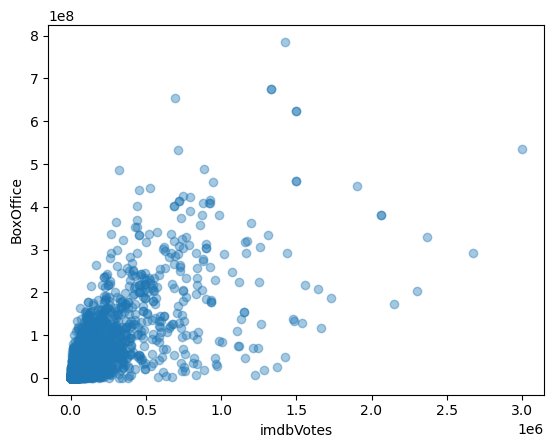

In [29]:
for feat in numeric_feats:
    plt.figure()
    plt.scatter(model_df[feat], model_df[target], alpha=0.4)
    plt.xlabel(feat)
    plt.ylabel(target)
    plt.show()

log_imdbVotes    0.749271
Runtime          0.247265
imdbRating       0.161926
Year            -0.109878
Name: log_BoxOffice, dtype: float64


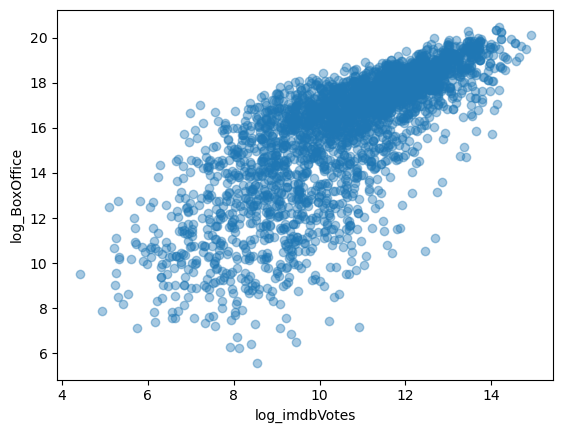

In [30]:
model_df['log_BoxOffice'] = np.log1p(model_df['BoxOffice'])
model_df['log_imdbVotes'] = np.log1p(model_df['imdbVotes'])
corrs_log = model_df[['log_imdbVotes', 'Year', 'Runtime', 'imdbRating', 'log_BoxOffice']] \
               .corr()['log_BoxOffice'] \
               .drop('log_BoxOffice') \
               .sort_values(ascending=False)
print(corrs_log)
plt.scatter(model_df['log_imdbVotes'], model_df['log_BoxOffice'], alpha=0.4)
plt.xlabel('log_imdbVotes')
plt.ylabel('log_BoxOffice')
plt.show()


# PREDICT THE LOG OF BOX OFFICE TOO. MIGHT BE MORE RELIABLE THAN SIMPLE BOX OFFICE


In [ ]:
project_root = Path().resolve().parent
df = pd.read_csv(project_root / "data_collection" / "omdb_cleaned.csv")

mask = ~df['Year'].astype(str).str.match(r'^\d{4}$', na=False)
df = df.loc[~mask].copy()
df['Year'] = df['Year'].astype(int)
df['Runtime'] = pd.to_numeric(
    df['Runtime'].astype(str).str.extract(r'(\d+)', expand=False),
    errors='coerce'
)

df['log_BoxOffice'] = np.log1p(df['BoxOffice'])
df['log_imdbVotes'] = np.log1p(df['imdbVotes'])

#top 10 genres
genres = df['Genre'].apply(lambda x: x.split('|') if isinstance(x, str) else [])
mlb = MultiLabelBinarizer()
genre_ohe = pd.DataFrame(
    mlb.fit_transform(genres),
    columns=mlb.classes_,
    index=df.index
)
top10 = genre_ohe.sum().nlargest(10).index
df[top10] = genre_ohe[top10]

X = df[['log_imdbVotes', 'imdbRating', 'Runtime', 'Year'] + top10.tolist()]
y = df['log_BoxOffice']
mask2 = X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask2], y.loc[mask2]

# ols regression
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
pipeline.fit(X, y)

#coeffs + r^2
coefs = pipeline.named_steps['linearregression'].coef_
coef_series = pd.Series(coefs, index=X.columns).sort_values(key=abs, ascending=False)
print("Standardized coefficients:\n", coef_series)
print("\nR²:", pipeline.score(X, y))

Standardized coefficients:
 log_imdbVotes                   2.353873
Year                           -0.653980
imdbRating                     -0.640520
Animation, Adventure, Comedy    0.304885
Runtime                         0.199809
Documentary                     0.103207
Comedy, Romance                 0.101243
Comedy, Drama, Romance          0.080984
Drama                          -0.055252
Comedy                          0.053907
Action, Adventure, Sci-Fi       0.039975
Action, Crime, Drama            0.023596
Drama, Romance                  0.017904
Comedy, Drama                  -0.009058
dtype: float64

R²: 0.6493420675324744


# make dummies for genres

example
film has drama = 0 or drama = 1 